In [17]:
@time using CSV                          # CSVファイルの操作のためのパッケージ
@time using DataFrames                   # データフレーム
@time using Distributions                # 確率分布
@time using NLsolve                      # 非線形方程式の近似根を求める
@time using Plots                        # グラフ描画
@time using Parameters                   # 数値モデルのパラメーターを処理するために使用するパッケージ
@time using QuadGK                       # 1次元の数値積分
@time using SpecialFunctions             # 特殊関数
@time using StatsBase                    # 統計にかかわる基本的な関数群が提供されているパッケージ

  2.126940 seconds (5.67 M allocations: 327.189 MiB, 4.19% gc time, 89.99% compilation time)
  0.000058 seconds (108 allocations: 9.469 KiB)
  0.000058 seconds (108 allocations: 9.469 KiB)
  0.130562 seconds (423.68 k allocations: 25.995 MiB, 5.74% compilation time)
  0.000076 seconds (108 allocations: 9.469 KiB)
  0.000027 seconds (109 allocations: 9.516 KiB)
  0.000023 seconds (109 allocations: 9.516 KiB)
  0.000036 seconds (109 allocations: 9.531 KiB)
  0.000049 seconds (109 allocations: 9.516 KiB)


アルゴリズム：期間[0,T]における条件付き強度関数
$$
λ(t|H_t)=μ+\displaystyle \sum_{t<t_i} g(t-t_i)
$$
                 のホークス過程のシミュレーション

1.λ^*←μ,t^*←0,i←0 とする\
2.以下を繰り返す.\
 - 2.1 期待値1/λ^*の指数分布に従う乱数Eを生成し、次のイベント時刻t^*←t^*+Eとする.t^*>Tならばステップ3へ.\
 - 2.2 採択確率r←λ(t^*|H_t)/λ^*を計算し、一様乱数Uを生成する.U \leq rならば候補を採択し、i←i+1,t_i←t^*とする.そうでなければ棄却する.\
 - 2.3 候補が採択された場合はλ^*←λ(t^*|H_t)とする.ステップ2へ戻る.\
 
3.イベント列{t_i}を出力する.

In [2]:
using Pkg
Pkg.add("Distributions")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Bzip2_jll ─ v1.0.8+1
  No Changes to `~/.julia/environments/v1.7/Project.toml`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [6e34b625] ↑ Bzip2_jll v1.0.8+0 ⇒ v1.0.8+1
Precompiling project...
  ✓ Bzip2_jll
  ✓ FreeType2_jll
  ✓ Fontconfig_jll
  ✓ FreeType
  ✓ Cairo_jll
  ✓ Qt5Base_jll
  ✓ HarfBuzz_jll
  ✓ libass_jll
  ✓ FreeTypeAbstraction
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GR_jll
  ✓ GR
  ✓ UnicodePlots
  ✓ CategoricalDistributions
  ✓ Plots
  16 dependencies successfully precompiled in 29 seconds (186 already precompiled)


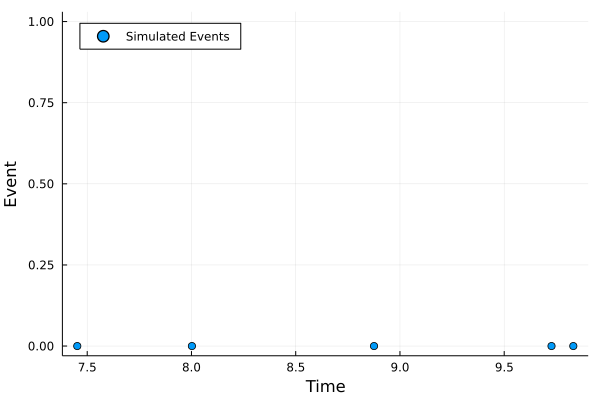

In [1]:
using Plots
using Distributions

function hawkes_intensity(t, mu, past_events, g)
    return mu + sum(g.(t .- past_events[past_events .< t]))
end

function simulate_hawkes_process(T, mu, g)
    lambda_star = mu
    t_star = 0.0
    events = Float64[]

    while t_star < T
        # 2.1 Generate random time interval until the next event
        E = rand(Exponential(1 / lambda_star))
        t_star += E

        if t_star > T
            break  # Exit if t_star exceeds the simulation period
        end

        # 2.2 Calculate acceptance probability
        lambda_t = hawkes_intensity(t_star, mu, events, g)
        r = lambda_t / lambda_star

        # 2.2 Accept or reject the candidate
        if rand() <= r
            push!(events, t_star)
            lambda_star = lambda_t
        end
    end

    return events
end

# Parameters
T = 10.0
mu = 0.1
g(t) = exp(-0.1 * t)  # Example kernel function

# Simulation
events = simulate_hawkes_process(T, mu, g)

# Plotting
plot(events, zeros(size(events)), seriestype = :scatter, xlabel="Time", ylabel="Event", label="Simulated Events", legend=:topleft)


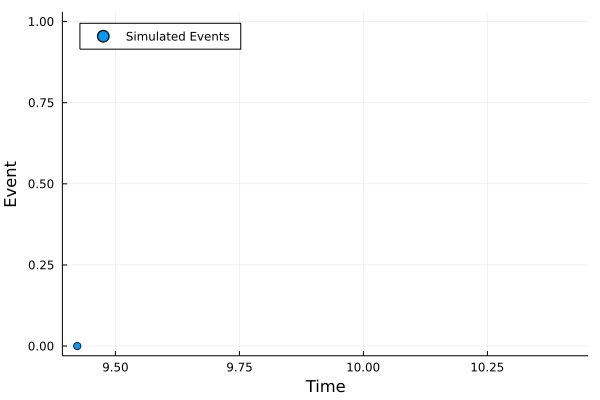

In [4]:
using Plots
using Distributions

function hawkes_intensity(t, mu, alpha, beta, past_events)
    return mu + alpha * sum(exp.(-beta .* (t .- past_events[past_events .< t])))
end

function simulate_hawkes_process(T, mu, alpha, beta)
    lambda_star = mu
    t_star = 0.0
    events = Float64[]

    while t_star < T
        # 2.1 Generate random time interval until the next event
        E = rand(Exponential(1 / lambda_star))
        t_star += E

        if t_star > T
            break  # Exit if t_star exceeds the simulation period
        end

        # 2.2 Calculate acceptance probability
        lambda_t = hawkes_intensity(t_star, mu, alpha, beta, events)
        r = lambda_t / lambda_star

        # 2.2 Accept or reject the candidate
        if rand() <= r
            push!(events, t_star)
            lambda_star = lambda_t
        end
    end

    return events
end

# Parameters
T = 10.0
mu = 0.1
alpha = 0.5
beta = 1.0

# Simulation
events = simulate_hawkes_process(T, mu, alpha, beta)

# Plotting
plot(events, zeros(size(events)), seriestype = :scatter, xlabel="Time", ylabel="Event", label="Simulated Events", legend=:topleft)


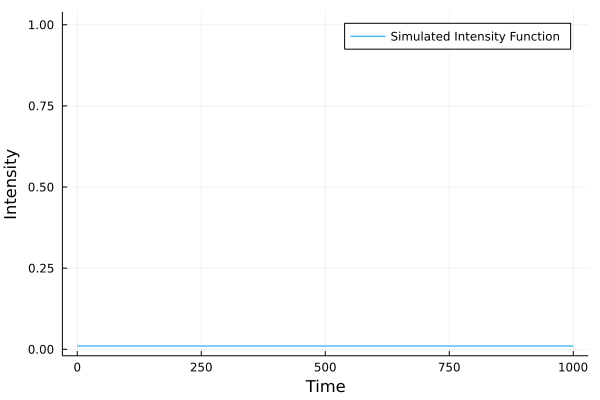

In [9]:
using Plots

function hawkes_intensity(t, mu, alpha, beta, past_events)
    return mu + alpha * sum(exp.(-beta .* (t .- past_events[past_events .< t])))
end

function simulate_intensity_function(T, mu, alpha, beta)
    dt = 0.1  # 時間の刻み幅
    times = 0:dt:T
    intensity_values = Float64[]

    past_events = Float64[]

    for t in times
        push!(intensity_values, hawkes_intensity(t, mu, alpha, beta, past_events))
    end

    return times, intensity_values
end

# Parameters
T = 1000.0
mu = 0.01
alpha = 0.99
beta = 1.0

# Simulation
times, intensity_values = simulate_intensity_function(T, mu, alpha, beta)

# Plotting
plot(times, intensity_values, xlabel="Time", ylabel="Intensity", label="Simulated Intensity Function", legend=:topright)



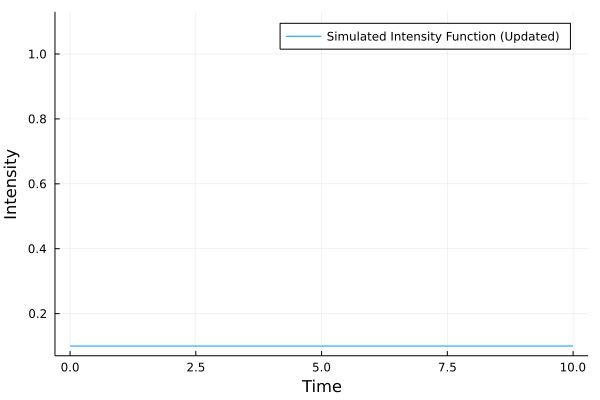

In [10]:
function hawkes_intensity(t, mu, alpha, beta, past_events)
    return mu + alpha * sum(exp.(-(t .- past_events[past_events .< t]) ./ beta) / beta)
end

function simulate_intensity_function(T, mu, alpha, beta)
    dt = 0.1  # 時間の刻み幅
    times = 0:dt:T
    intensity_values = Float64[]

    past_events = Float64[]

    for t in times
        push!(intensity_values, hawkes_intensity(t, mu, alpha, beta, past_events))
    end

    return times, intensity_values
end

# Parameters
T = 10.0
mu = 0.1
alpha = 0.5
beta = 1.0

# Simulation
times, intensity_values = simulate_intensity_function(T, mu, alpha, beta)

# Plotting
using Plots
plot(times, intensity_values, xlabel="Time", ylabel="Intensity", label="Simulated Intensity Function (Updated)", legend=:topright)


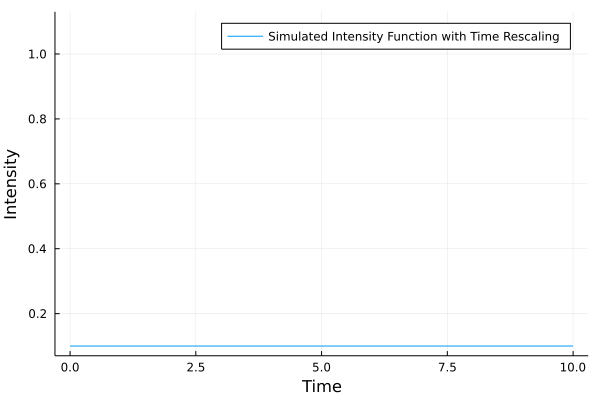

In [11]:
function hawkes_intensity(t, mu, alpha, beta, past_events)
    return mu + alpha * sum(exp.(-(t .- past_events) ./ beta) / beta)
end

function simulate_intensity_function(T, mu, alpha, beta)
    dt = 0.1  # 時間の刻み幅
    times = 0:dt:T
    intensity_values = Float64[]

    past_events = Float64[]

    t_star = 0.0
    i = 0

    while t_star <= T
        E = rand(Exponential(1 / hawkes_intensity(t_star, mu, alpha, beta, past_events)))
        t_star += E
        if t_star > T
            break
        end

        r = hawkes_intensity(t_star, mu, alpha, beta, past_events) / (mu + alpha * sum(exp.(-(t_star .- past_events) ./ beta) / beta))
        U = rand()

        if U ≤ r
            i += 1
            push!(past_events, t_star)
        end
    end

    for t in times
        push!(intensity_values, hawkes_intensity(t, mu, alpha, beta, past_events))
    end

    return times, intensity_values
end

# Parameters
T = 10.0
mu = 0.1
alpha = 0.5
beta = 1.0

# Simulation
times, intensity_vaintensity_values
plot(times, intensity_values, xlabel="Time", ylabel="Intensity", label="Simulated Intensity Function with Time Rescaling", legend=:topright)


In [12]:
intensity_values

101-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 ⋮
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [15]:
past_events = Float64[]
for t in times
    push!(intensity_values, hawkes_intensity(t, mu, alpha, beta, past_events))
end
intensity_values

303-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 ⋮
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [22]:
# 非線形方程式 ( Non-linear equations )
@inline fun(t,λ0,λ,τ,ω,K,Δ) = λ0*t+sum([λ[i,1]*τ[i]*(1-exp(-t/τ[i])) for i in 1:K])-Δ*ω/log(ω+1)

# 解の導出 Find solutions to non-linear equations
@inline function nls(func, params...; ini = [0.0]) 
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls(fun,0.01,0.99,1.0,2.0,1,rand(Exponential(1)),ini=0.0) # (近似根, true : 近似根 f=0 を満たす) 

(0.9924045371106801, true)

  0.194848 seconds (922.52 k allocations: 40.254 MiB, 96.18% compilation time)
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           1.002925
Minimum:        0.020059
1st Quartile:   0.610281
Median:         0.936151
3rd Quartile:   1.318430
Maximum:        4.320185
Type:           Float64
describe(df.Intensity) = nothing


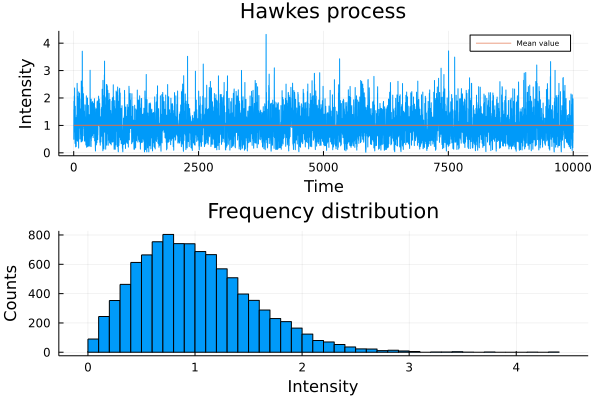

In [50]:
using Distributions
using DataFrames
using Plots

# Jump function
function jump(t, λ, τ, n)
    λ * exp(-t / τ) + n / τ
end

# No jump function
function no_jump(λ, τ, t)
    λ * exp(-t / τ)
end

# Event times generation
function generate_event_times(T, N)
    t = rand(Uniform(0.0, T), N)
    sort!(t)
    return t
end

# Time-rescaling theorem simulation for Hawkes process
function hawkes_simulation(T, N, K, n, ω, λ0)
    λt = zeros(N)
    λ = zeros(K, 2)
    tΔ = zeros(2)
    
    # Event times
    t = generate_event_times(T, N)
    
    # Time decay parameter τ
    τ = rand(Uniform(1.0, 3.0), K)
    
    # Branching ratio n
    n_values = fill(n / K, K)
    
    # Cumulative distribution function
    CDF = ζ(ω)
    
    # Initializations
    Δ = 0.0
    tΔ[2] = Δ
    m = ξ(ω, CDF)
    λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
    
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0 + sum([no_jump(λ[i, 1], τ[i], δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:, 1] .= λ[:, 2]
                Δ = rand(Exponential(1))
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω, CDF)
                λ[:, 2] .= [jump(Δ, λ[i, 1], τ[i], n_values[i]) for i in 1:K]
            end
        end
    end
    
    return t, λt
end

# Parameters
par = (
    K = 5,     # Number of exponential kernel functions
    n = 0.99,  # Branching ratio
    ω = 0.01,  # Exponential kernel parameter
    λ0 = 0.01  # Initial intensity
)

# Simulation
T = 10^4
N = 10^4
@time t, λt = hawkes_simulation(T, N, par.K, par.n, par.ω, par.λ0)

# DataFrame
df = DataFrame(Time = t, Intensity = λt)
@show describe(df.Intensity)

# Plot
plt = plot(df.Time, df.Intensity, xlabel="Time", ylabel="Intensity", title="Hawkes process", label="")
hist = histogram(df.Intensity, xlabel="Intensity", ylabel="Counts", title="Frequency distribution", label="")
plot(plot!(plt, x -> mean(df.Intensity), label="Mean value", legendfontsize=5), hist, layout=(2, 1))


  0.316481 seconds (1.42 M allocations: 58.792 MiB, 95.26% compilation time)
describe(df_2D) = 3×7 DataFrame
 Row │ variable    mean         min        median       max         nmissing  eltype
     │ Symbol      Float64      Float64    Float64      Float64     Int64     DataType
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │ Time        5010.63      1.29352    4995.05      9999.82            0  Float64
   2 │ Intensity1     0.983086  0.0369418     0.915589     3.39948         0  Float64
   3 │ Intensity2     0.982568  0.0425592     0.926053     3.02819         0  Float64


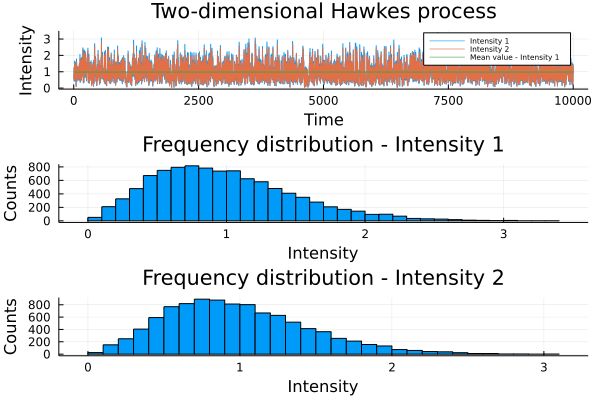

In [40]:
using Distributions
using DataFrames
using Plots

# Jump function for exponential kernel
function jump(t, λ, τ, n)
    λ * exp(-t / τ) + n / τ
end

# No jump function for exponential kernel
function no_jump(λ, τ, t)
    λ * exp(-t / τ)
end

# Event times generation
function generate_event_times(T, N)
    t = rand(Uniform(0.0, T), N)
    sort!(t)
    return t
end

# Time-rescaling theorem simulation for two-dimensional Hawkes process
function hawkes_simulation_2D(T, N, K, n1, n2, ω1, ω2, λ0)
    λt1 = zeros(N)
    λt2 = zeros(N)
    λ1 = zeros(K, 2)
    λ2 = zeros(K, 2)
    tΔ = zeros(2)
    
    # Event times
    t = generate_event_times(T, N)
    
    # Time decay parameters τ
    τ1 = rand(Uniform(1.0, 3.0), K)
    τ2 = rand(Uniform(1.0, 3.0), K)
    
    # Branching ratios n
    n_values1 = fill(n1 / K, K)
    n_values2 = fill(n2 / K, K)
    
    # Cumulative distribution functions
    CDF1 = ζ(ω1)
    CDF2 = ζ(ω2)
    
    # Initializations
    Δ = 0.0
    tΔ[2] = Δ
    m1 = ξ(ω1, CDF1)
    m2 = ξ(ω2, CDF2)
    λ1[:, 2] .= [jump(Δ, λ1[i, 1], τ1[i], n_values1[i]) for i in 1:K]
    λ2[:, 2] .= [jump(Δ, λ2[i, 1], τ2[i], n_values2[i]) for i in 1:K]
    
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt1[i] = λ0 + sum([no_jump(λ1[i, 1], τ1[i], δ) for i in 1:K])
                λt2[i] = λ0 + sum([no_jump(λ2[i, 1], τ2[i], δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ1[:, 1] .= λ1[:, 2]
                λ2[:, 1] .= λ2[:, 2]
                Δ = rand(Exponential(1))
                tΔ[2] = tΔ[1] + Δ
                m1 = ξ(ω1, CDF1)
                m2 = ξ(ω2, CDF2)
                λ1[:, 2] .= [jump(Δ, λ1[i, 1], τ1[i], n_values1[i]) for i in 1:K]
                λ2[:, 2] .= [jump(Δ, λ2[i, 1], τ2[i], n_values2[i]) for i in 1:K]
            end
        end
    end
    
    return t, λt1, λt2
end

# Parameters for the two-dimensional Hawkes process
par_2D = (
    K = 5,      # Number of exponential kernel functions
    n1 = 0.99,  # Branching ratio for the first intensity
    n2 = 0.99,  # Branching ratio for the second intensity
    ω1 = 0.01,  # Exponential kernel parameter for the first intensity
    ω2 = 0.01,  # Exponential kernel parameter for the second intensity
    λ0 = 0.01   # Initial intensity
)

# Simulation for the two-dimensional Hawkes process
T = 10^4
N = 10^4
@time t, λt1, λt2 = hawkes_simulation_2D(T, N, par_2D.K, par_2D.n1, par_2D.n2, par_2D.ω1, par_2D.ω2, par_2D.λ0)

# DataFrame
df_2D = DataFrame(Time = t, Intensity1 = λt1, Intensity2 = λt2)
@show describe(df_2D)

# Plot for the two-dimensional Hawkes process
plt_2D = plot(df_2D.Time, [df_2D.Intensity1, df_2D.Intensity2], xlabel="Time", ylabel="Intensity", title="Two-dimensional Hawkes process", label=["Intensity 1" "Intensity 2"])
hist_2D_1 = histogram(df_2D.Intensity1, xlabel="Intensity", ylabel="Counts", title="Frequency distribution - Intensity 1", label="")
hist_2D_2 = histogram(df_2D.Intensity2, xlabel="Intensity", ylabel="Counts", title="Frequency distribution - Intensity 2", label="")
plot(plot!(plt_2D, x -> mean(df_2D.Intensity1), label="Mean value - Intensity 1", legendfontsize=5), hist_2D_1, hist_2D_2, layout=(3, 1))
